# Diabetes - Pima Indians

## Introduction

In this diabetes classification project, I aim to predict whether a patient has diabetes (1) or not (0) based on several health indicators. The dataset includes features such as the number of pregnancies, glucose level, blood pressure, skin thickness, insulin levels, BMI, diabetes pedigree function (which represents the likelihood of diabetes based on family history), and age. By analyzing these variables, I will build a machine learning model to classify patients into diabetic or non-diabetic categories, using the "Outcome" variable as the target for prediction.


## Importing Libraries

In [1]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
"""Scikit-learn version 1.6 modified the API around its 'tags' XGBoost has made the necessary changes in PR11021,
   but at present that hasn't made it into a released version.
   You can either keep your sklearn version <1.6, or build XGBoost directly from github"""
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Model evaluation (classification)
from sklearn.metrics import accuracy_score, recall_score

# Cross-validation and hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# Warnings
import warnings
warnings.filterwarnings("ignore")


Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


## Loading Data

**For more information [here](https://www.kaggle.com/datasets/nancyalaswad90/review)**

In [2]:
# Read Data
df = pd.read_csv('/content/diabetes.csv')

# First 10 rows
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


It seems that data has some issues. As some columns has values of 0 which doesn't make sense (such as 'Insulin' & 'SkinThickness')

## Data Cleaning

In this section i'll deal with:
* Null values.
* Outliers.

 Replace 0 with null on all columns except 'Pregnancies' and 'Outcome'

In [3]:

to_replace = [col for col in df.columns if col not in ['Pregnancies', 'Outcome']]
df[to_replace] = df[to_replace].replace(0, np.nan)

In [4]:
# Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [5]:
# Data statistics
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


percentages of null values on columns

In [6]:

per_null = df.isnull().sum() / len(df) * 100
per_null

,0
Pregnancies,0.000000
Glucose,0.651042
BloodPressure,4.557292
SkinThickness,29.557292
Insulin,48.697917
BMI,1.432292
DiabetesPedigreeFunction,0.000000
Age,0.000000
Outcome,0.000000


As i'll use imputing techniques for filling null values. I'll treat outliers first.

**Note: in the next commented code cells, I did outliers capping but later on i found that it reduced the model accuracy and what i think is that this happened because having diabetes is highly correlated with having apnormalities regarding Glucose levels, BMI and etc...**

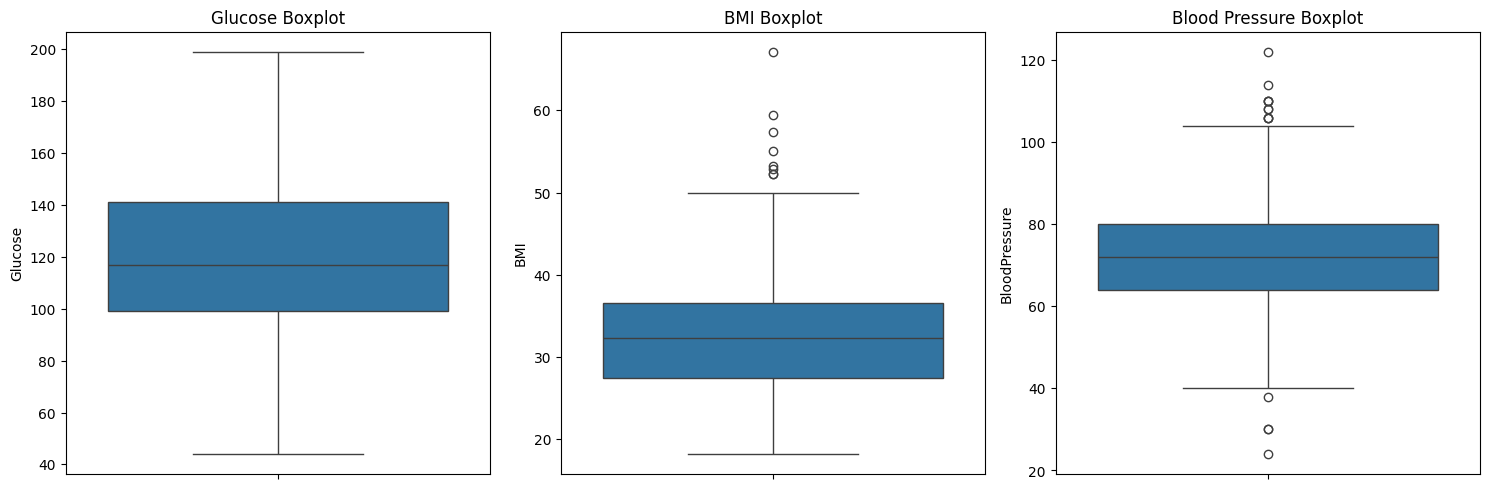

In [7]:
# Visualize features using boxplots to identify outliers
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['Glucose'])
plt.title('Glucose Boxplot')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['BMI'])
plt.title('BMI Boxplot')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['BloodPressure'])
plt.title('Blood Pressure Boxplot')

plt.tight_layout()
plt.show()

In [8]:
# assign upper bound 13 to any higher value in pregnancies
#df.loc[df['Pregnancies'] > 13, 'Pregnancies'] = 13

BloodPressure is in the normal range, even some points outside boxplot. No action will be taken.

In [9]:
# assign a value of 50 to any higher value in SkinThickness (as 50 considered an accepted upper value)
#df.loc[df['SkinThickness'] > 50, 'SkinThickness'] = 50

In [10]:
# assign a value of 400 for any higher in Insuline (as all refere to exteme diabetes conditions)
#df.loc[df['Insulin'] > 400, 'Insulin'] = 400

In [11]:
# assign a value of 40 for any higher value in BMI. As 40 is the value in extreme obesity (even there is no theoritical upper bound)
#df.loc[df['BMI'] > 40, 'BMI'] = 40

In [12]:
# assign a value of 2 to any higher in DiabetesPedigreeFunction (as 2 considered an upper bound for the feature)
#df.loc[df['DiabetesPedigreeFunction'] > 2, 'DiabetesPedigreeFunction'] = 2

Values outside 'Age' box plot considered normal for age range. So, no action will be taken.

**Now, i'll start treating null values**


I'll start treating null values from smallest to largest percentages.
**I have tried a lot of imputation methods including making groupby based on available rows and aggregate using mean for each group and I have also tried doing regression models to Impute the missing values but surprisngly the simple cell -grouping by output only and then imputing- below gave me the best accuracy and recall!**

In [13]:
#filling null values with the mean for each column
df_0 = df[df['Outcome'] == 0]
df_1 = df[df['Outcome'] == 1]
columns_fill = ['Glucose', 'BloodPressure', 'SkinThickness','BMI', 'Insulin', 'Age']
mean_values_0 = df_0[columns_fill].mean()
mean_values_1 = df_1[columns_fill].mean()
for column in columns_fill:
  df.loc[df['Outcome'] == 0, column] = df.loc[df['Outcome'] == 0, column].fillna(mean_values_0[column])
  df.loc[df['Outcome'] == 1, column] = df.loc[df['Outcome'] == 1, column].fillna(mean_values_1[column])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


## EDA

In this section i'll try to extract insights from the data through visualization.

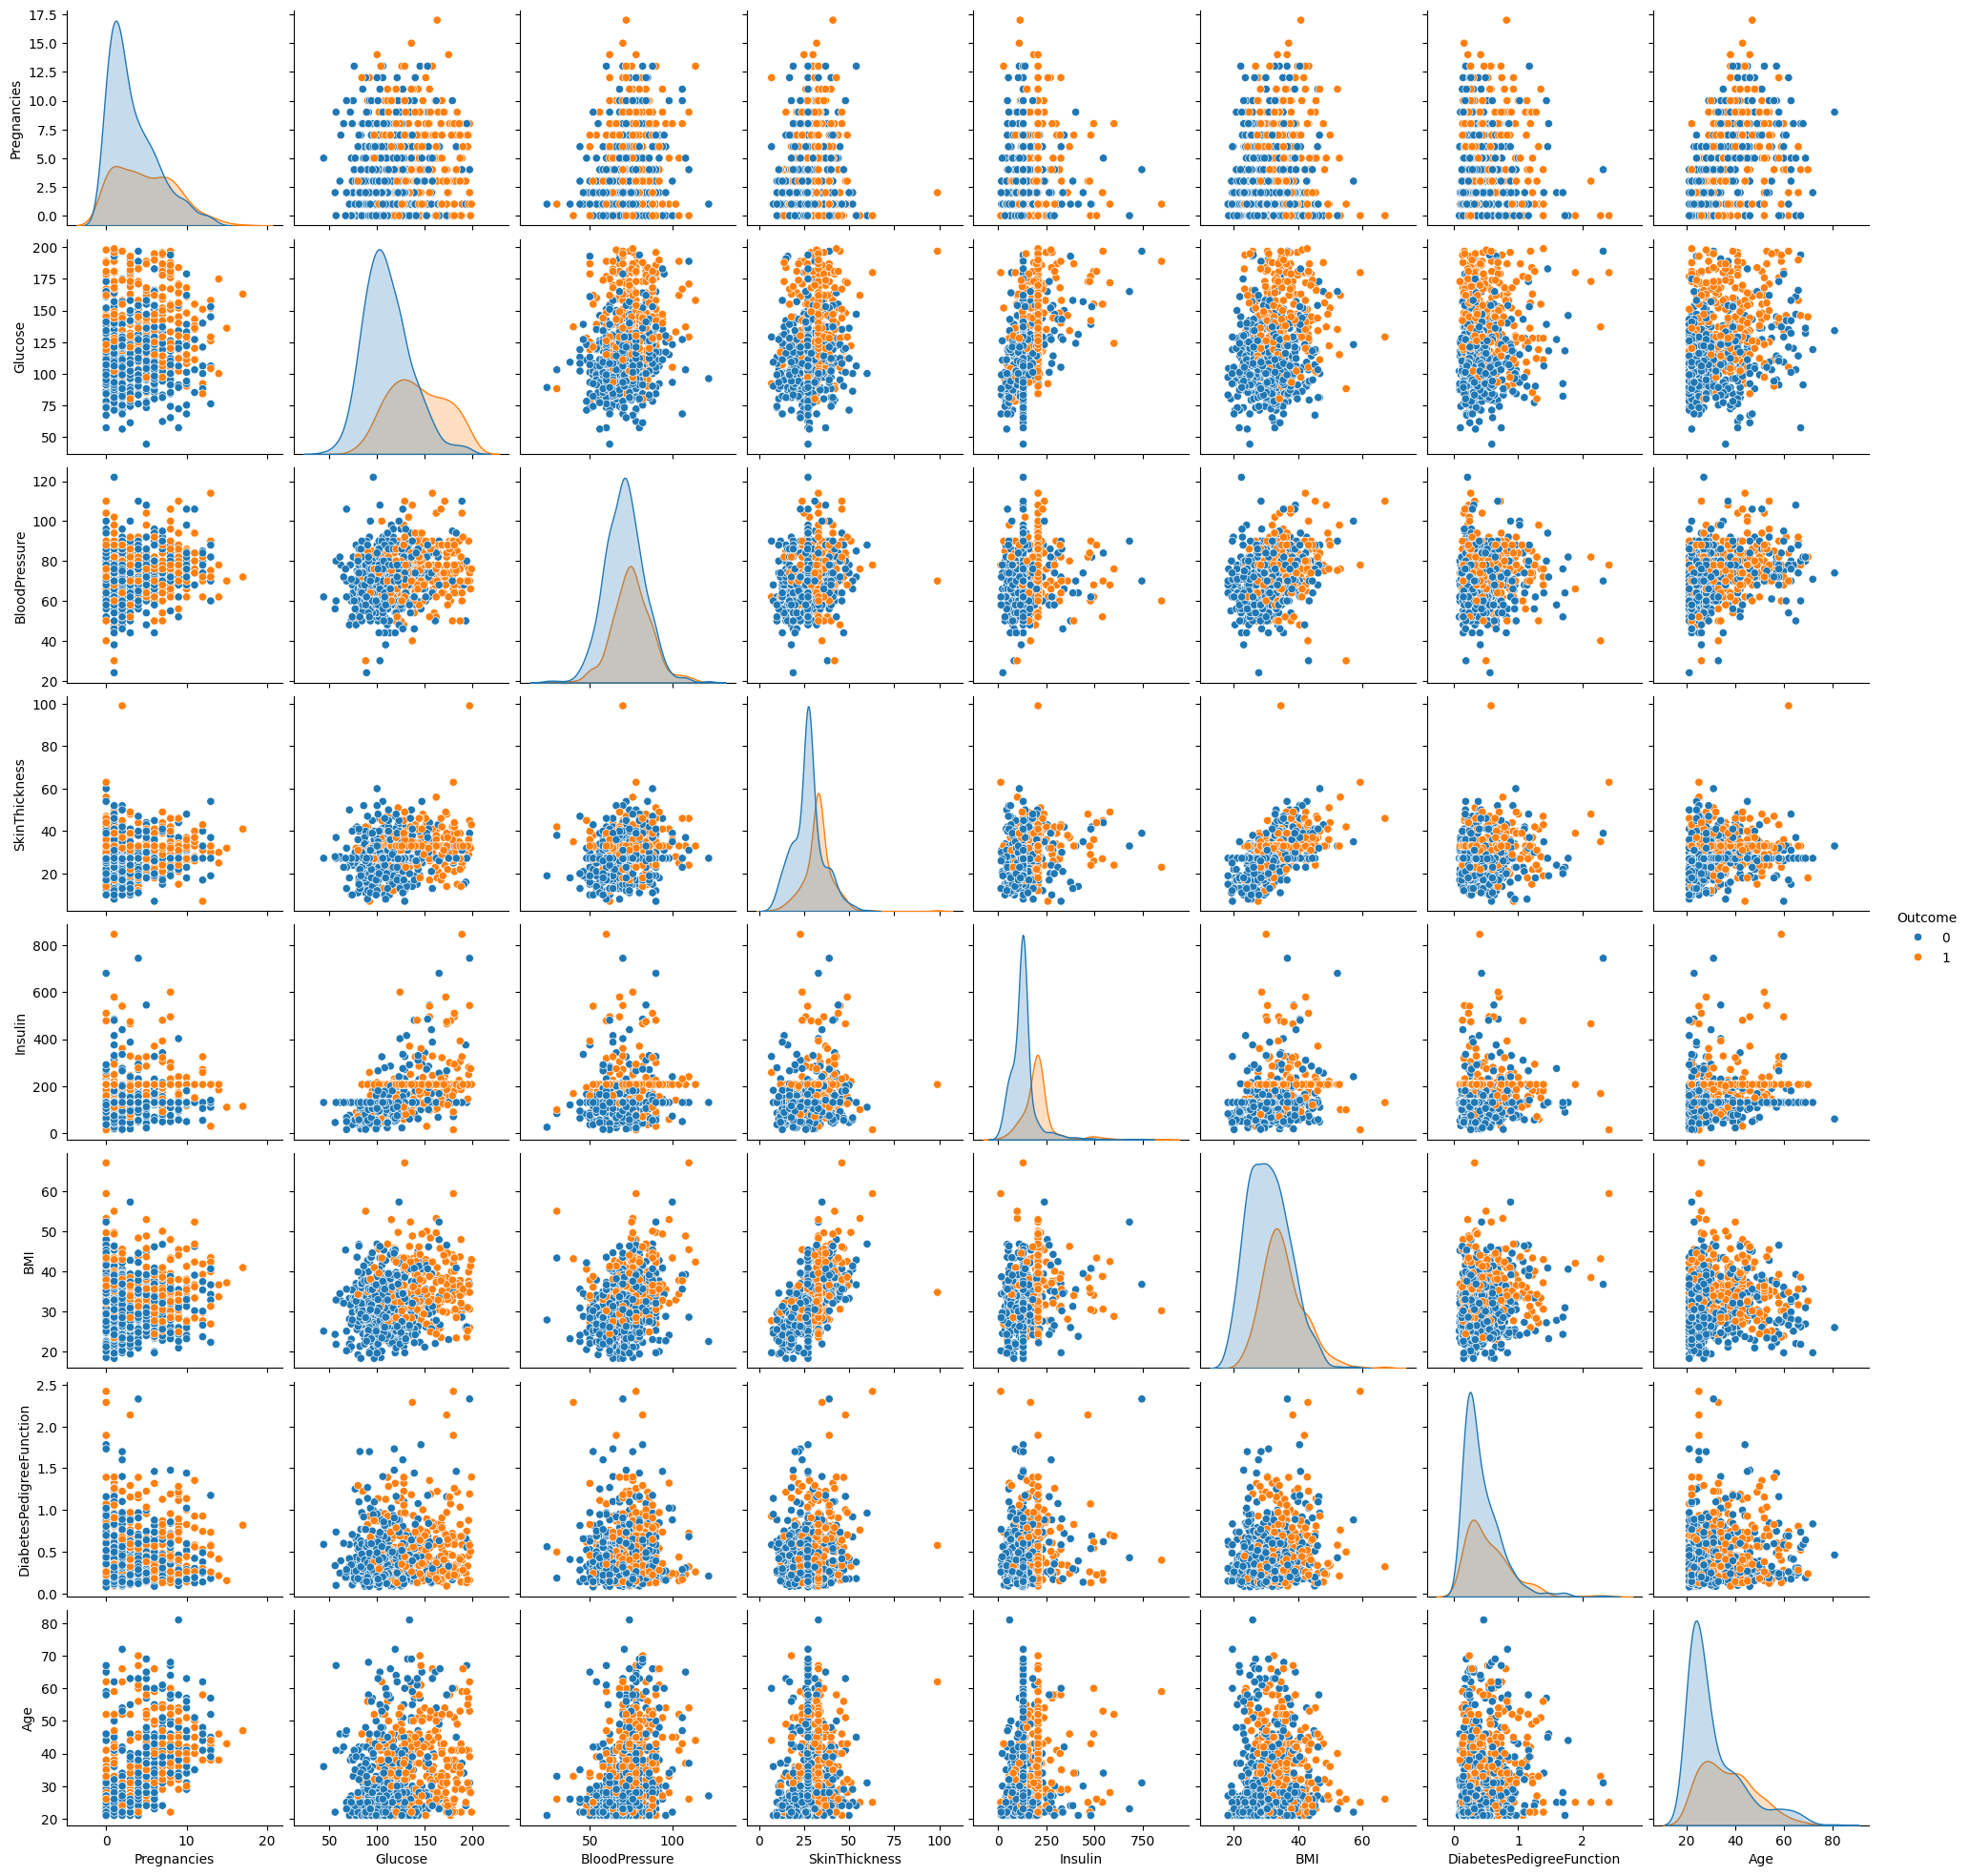

In [15]:
# explore data to try expect suitable model using pairplot
sns.pairplot(df, hue='Outcome')

one thing caught my eye is that Diabetes Pedigree Function -probality you have Diabetes given your family history- doesn't affect the probablity of you having diabetes that much if you are an healthy person. -look the the relation between DPF and BMI-

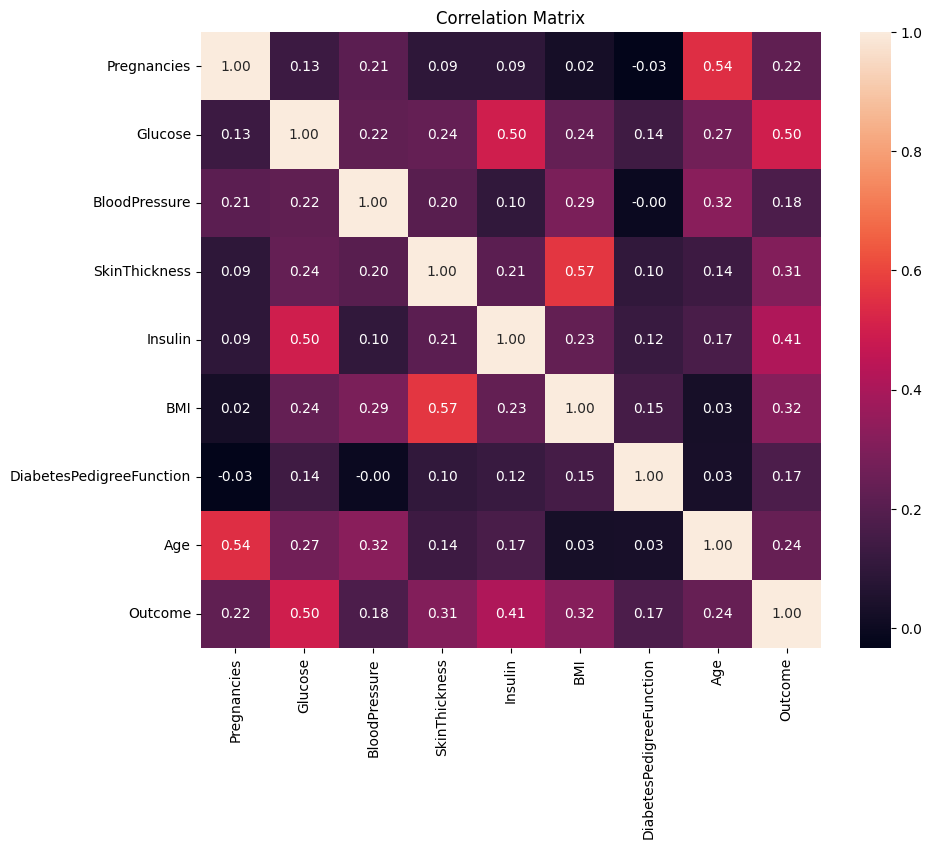

In [16]:
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

most of the variables that positively correlate to the outcome also positvely correlates to each other and this is strong indicator towards Multicollinearity.

**Interactive visualization to show and identify outliers**

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Identify columns to explore, excluding 'output'
to_explore = [col for col in df.columns if col not in ['output']]

# Loop through each column to create visualizations
for column in to_explore:
    # Calculate Q1, Q3, and IQR for outlier detection
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers based on the calculated bounds
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_count = len(outliers)

    # Create subplots: 1 row, 2 columns for Boxplot and Distplot
    fig = make_subplots(rows=1, cols=2, subplot_titles=(f'{column} - Boxplot', f'{column} - Distplot'))

    # Add Boxplot for the current column
    fig.add_trace(go.Box(
        y=df[column],
        name='Boxplot',
        boxmean='sd'  # Display standard deviation in the boxplot
    ), row=1, col=1)

    # Add Distplot (Density Plot) for the current column
    fig.add_trace(go.Histogram(
        x=df[column],
        name='Distplot',
        histnorm='probability density',  # Normalize histogram to probability density
        nbinsx=30,  # Number of bins
        opacity=0.6,  # Opacity of the bars
        marker_color='skyblue'  # Color of the bars
    ), row=1, col=2)

    # Add annotation for outlier count on the Boxplot
    fig.add_annotation(
        x=1,  # Position in the Boxplot
        y=df[column].max(),
        text=f'No Outliers: {outlier_count}',
        showarrow=False,
        ax=0,
        ay=-50,
        xref='x1',
        yref='y1'
    )

    # Update layout for better presentation
    fig.update_layout(
        title=f'Interactive Plot for {column}',
        xaxis_title='Values',
        yaxis_title='Density',
        xaxis2_title='Values',
        yaxis2_title='Density',
        height=600,
        width=1000,
        showlegend=False  # Hide legend
    )

    # Display the plot
    fig.show()


**Group numerical values into predifined bins and assign labels to them**

All ranges used for intervals on different columns depend on ranges of this feature in human body.

In [18]:
# Preg bins and labels
custom_bins = [-0.01, 5, 10, 13]
custom_labels = ['0-5', '5-10', '10-13']
# Create a new column 'preg_group'
df['preg_group'] = pd.cut(df['Pregnancies'], bins=custom_bins, labels=custom_labels)

# DiabetesPedigreeFunction bins and labels
custom_bins = [0, 1, 2]
custom_labels = ['0-1', '1-2']
# Create a new column 'DiabetesPedigreeFunction_group'
df['DiabetesPedigreeFunction_group'] = pd.cut(df['DiabetesPedigreeFunction'], bins=custom_bins, labels=custom_labels)

# Age	 bins and labels
custom_bins = [20, 40,60,81]
custom_labels = ['20-40','40-60','60-81']
# Create a new column 'Age_group'
df['Age_group'] = pd.cut(df['Age'], bins=custom_bins, labels=custom_labels)

# Glucose	 bins and labels
custom_bins = [40, 100, 125, 200]
custom_labels = ['40-100','100-125','125-200']
# Create a new column 'glu_group'
df['glu_group'] = pd.cut(df['Glucose'], bins=custom_bins, labels=custom_labels)

In [19]:
# Insulin bins and labels
custom_bins = [0, 2, 25, 50, 400]
custom_labels = ['0-2', '2-25', '25-50', '>50']
# Create a new column 'ins_group'
df['ins_group'] = pd.cut(df['Insulin'], bins=custom_bins, labels=custom_labels)

# BMI bins and labels
custom_bins = [0, 18.4, 24.9, 29.9, 40]
custom_labels = ['Underweight', 'Normal Weight', 'Overweight', 'Obesity']
# Create a new column 'bmi_group'
df['bmi_group'] = pd.cut(df['BMI'], bins=custom_bins, labels=custom_labels)

# BloodPressure bins and labels
custom_bins = [0, 80, 89, 120, 122]
custom_labels = ['Normal', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis']
# Create a new column 'bmi_group'
df['bp_group'] = pd.cut(df['BloodPressure'], bins=custom_bins, labels=custom_labels)

# SkinThickness bins and labels
custom_bins = [0, 10, 20, 30, 50]
custom_labels = ['Low ', 'Normal ', 'High ', 'Extreme ']
# Create a new column 'sk_group'
df['sk_group'] = pd.cut(df['SkinThickness'], bins=custom_bins, labels=custom_labels)


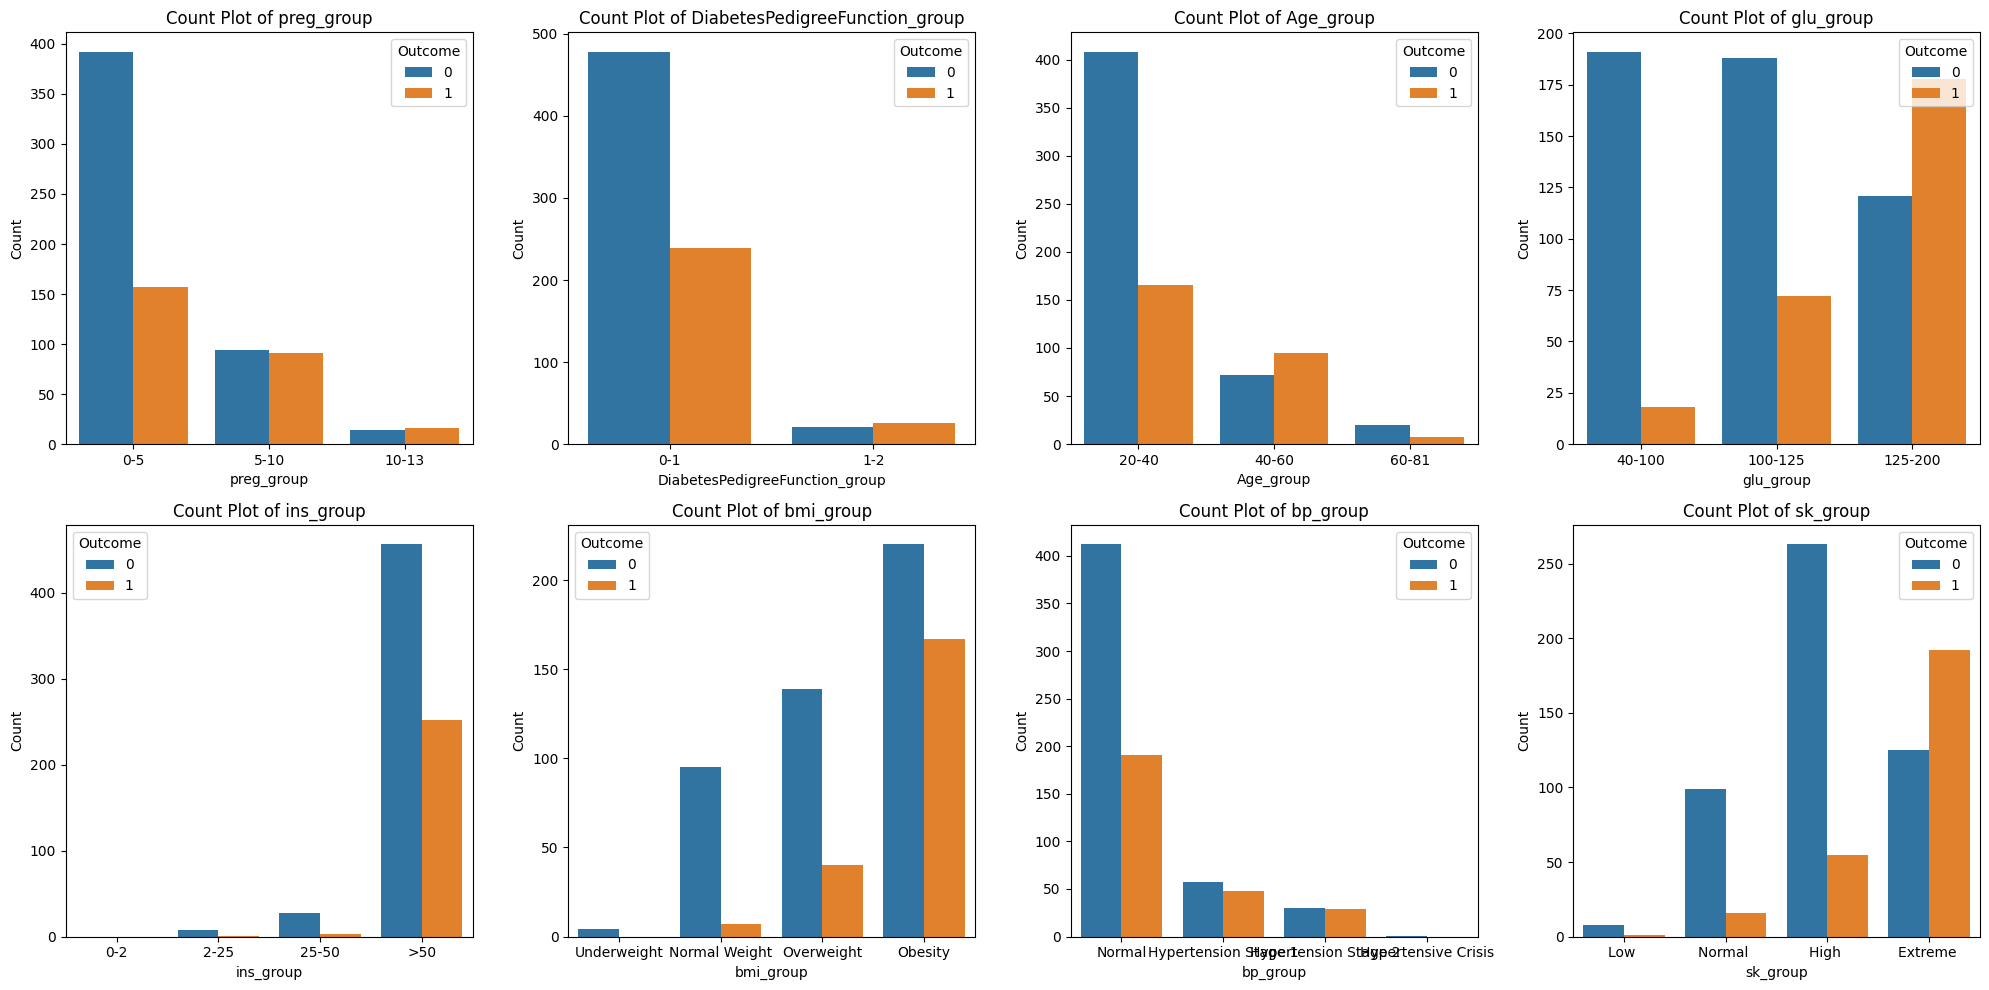

In [20]:
# Columns to plot and hue column
columns_to_plot = ['preg_group', 'DiabetesPedigreeFunction_group', 'Age_group', 'glu_group', 'ins_group', 'bmi_group', 'bp_group', 'sk_group']
hue_column = 'Outcome'

# Set up the subplots: 2 rows and 4 columns
num_columns = len(columns_to_plot)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each column and create a count plot
for ax, col in zip(axes, columns_to_plot):
    sns.countplot(x=col, hue=hue_column, data=df, ax=ax)
    ax.set_title(f'Count Plot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

# Remove any unused subplots
for ax in axes[len(columns_to_plot):]:
    ax.remove()

plt.tight_layout()
plt.show()

This shows that with increasing number of pregnancies, the probability of diabetes increases.

It seems that the age has no direct effect on diabetes probability, as we see variation in figure for different age intervals in random distribution.

For Glucose the figure shows that it has a high effect on the diabetes probability as it increasing with higher levels of glucose.

For the Diabetes Pedigree Function, values within the normal range (0-1) suggest that the likelihood of diabetes may depend on other factors. However, when the Diabetes Pedigree Function value falls within a higher range (1-2), it indicates a stronger genetic predisposition to diabetes based on family history.

For Insulin and BMI, it seems that they will relate to diabetes at extreme cases. Oherwise their relation almost nothing.

For BloodPressure there is no relation according to this data as in extreme cases the behaviour of the Diabetes doesn't change.

It is obvious that increasing skin thickness is high indicator to increasing probability of diabetes -it has high positive correlation with BMI-.

## Data Preprocessing

In this section i'll perform:
* Data Scalling


In [21]:
# define data
X_dia = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
y_dia = df['Outcome']

# split data to train and test
X_train_dia,X_test_dia, y_train_dia, y_test_dia =  train_test_split(X_dia, y_dia, test_size=0.2, random_state=0)

# scaling data
scaler = StandardScaler()
X_train_dia = scaler.fit_transform(X_train_dia)
X_test_dia = scaler.transform(X_test_dia)

## Classification Modeling

Here i'll create classification models to classify Diabetes.

In [22]:
# create classification models
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    SVC(),
    KNeighborsClassifier(),
    GaussianNB(),
    XGBClassifier()
]

# Loop in models
for model in models:
    model.fit(X_train_dia, y_train_dia)
    y_pred_dia = model.predict(X_test_dia)
    recall = recall_score(y_test_dia, y_pred_dia)

    print(f'{model.__class__.__name__}: Recall = {recall:.4f}')
    print(f'accuracy: {model.score(X_test_dia, y_test_dia)}')

LogisticRegression: Recall = 0.6170
accuracy: 0.8051948051948052
DecisionTreeClassifier: Recall = 0.7660
accuracy: 0.8766233766233766
RandomForestClassifier: Recall = 0.8936
accuracy: 0.9090909090909091
GradientBoostingClassifier: Recall = 0.8723
accuracy: 0.8961038961038961
AdaBoostClassifier: Recall = 0.8936
accuracy: 0.8961038961038961
SVC: Recall = 0.7660
accuracy: 0.8506493506493507
KNeighborsClassifier: Recall = 0.7447
accuracy: 0.8311688311688312
GaussianNB: Recall = 0.6809
accuracy: 0.8181818181818182
XGBClassifier: Recall = 0.9149
accuracy: 0.8896103896103896


since this data indicated a sign of multicollinearity in the EDA section, and recalling the fact that tree based models are robust to multicollinearity, Algorithms like RandomForestClassifier, GradientBoostingClassifier AdaBoostClassifier and XGBClassifier gave me the best performance.

I'm interested in **Recall** as it's more important for me in Diabetes Classification, as the critical thing is the **False Negative (telling the patient that he is healthy while he is sick)**.

most of the models gives near results, with XGBClassifier is the highest.

In [23]:

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = XGBClassifier(random_state=0)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=50,
                                   scoring='recall', cv=5, verbose=1, random_state=0, n_jobs=-1)
random_search.fit(X_train_dia, y_train_dia)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Evaluate the best model on the test set
best_xgb_model = random_search.best_estimator_
y_pred_dia = best_xgb_model.predict(X_test_dia)
recall = recall_score(y_test_dia, y_pred_dia)
print(f'XGBoost (Tuned): Recall = {recall:.4f}')
print(f'accuracy: {best_xgb_model.score(X_test_dia, y_test_dia)}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best score: 0.8192929292929293
XGBoost (Tuned): Recall = 0.9149
accuracy: 0.9025974025974026


Recall still the same but got a bit better on accuracy

## Data Profiling

Here i'll explore the importance of features.

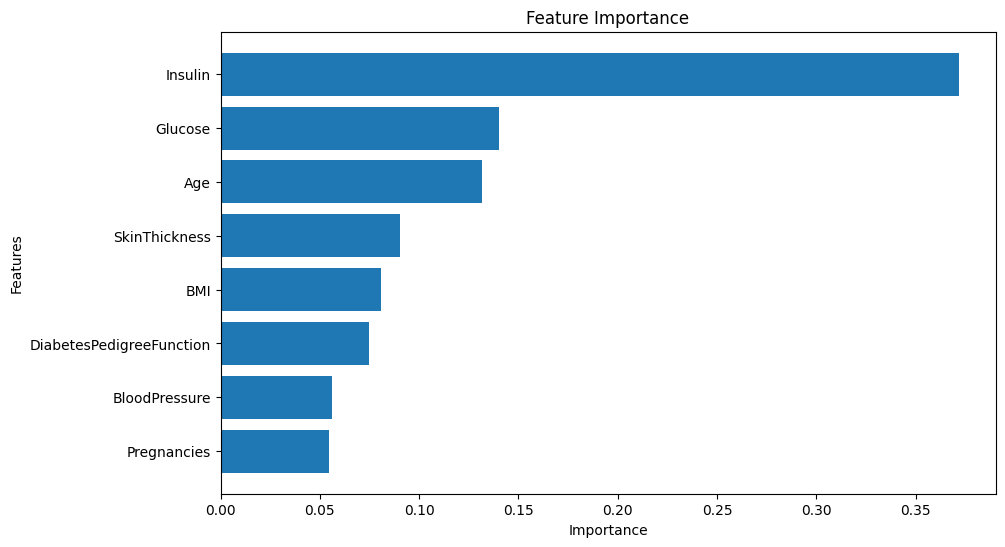

In [24]:
# Fit the XGBClassifier
model = best_xgb_model

# Get feature importances
importances = model.feature_importances_

# Get feature names from the training data
features = X_dia.columns

# Create a DataFrame for better handling and sort by importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the importances in descending order
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

This shows that Insulin has the highest efffect with a high difference from other features.

Glucose is highly correlated with insulin and it's clear that affects the outcome from the EDA section

Age is correlated with the outcome and this is also recognized from the EDA and from Domain Knowledge around us

SkinThickness, BMI, DiabetesPedigreeFunction and BloodPressure all affects the overall health and correlated with the ouctome

In [25]:
# saving the model
import pickle
from sklearn.preprocessing import StandardScaler

# Combine the model and scaler into a single pipeline object
pipeline = {
    'model': best_xgb_model,
    'scaler': scaler
}

with open('diabetes_prediction_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# Download the saved model file
from google.colab import files
files.download('diabetes_prediction_pipeline.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion

In this diabetes classification project, I analyzed key features such as 'Glucose', 'BMI', and 'Age' to predict diabetes outcomes, with feature importance rankings revealing 'Insulin' as the most influential factor and according to science that's a fact, higher levels of Insulin leads to Insulin resistance and later on Pre-diabetes and type 2 Diabetes. Several machine learning models were tested, including Logistic Regression, Decision Tree, Random Forest, and XGBoost. Among these, XGBClassifier achieved the highest recall of 0.9149, making it the most effective model for identifying true positive diabetes cases, which aligns with my primary goal of maximizing recall to minimize missed diagnoses.